In [13]:
import h5py

file_path = "/home/baoheng/OpenFOAM_study/UB_wind_tunnel_simulation_LES/0_test/windfield_all_cases.h5"

with h5py.File(file_path, "r") as f:
    # 1. 列出所有 case
    cases = list(f.keys())
    print("已有 case：", cases)

    for case in cases:
        case_grp = f[case]
        print(f"\n=== Case: {case} ===")
        print("时间序列 dtype:", case_grp["time"].dtype, "shape:", case_grp["time"].shape)
        print("时间步：", case_grp["time"][:10], "...")  # 只显示前10个

        # 2. 检查该 case 中的一个时间步（例如 t=0.005）
        t_str = "0.005"
        if t_str in case_grp:
            print(f"\n{case} -> t = {t_str} 的数据：", list(case_grp[t_str].keys()))
            print("  coords shape:", case_grp[t_str]["coords"].shape,
                  "dtype:", case_grp[t_str]["coords"].dtype)
            print("  velocity shape:", case_grp[t_str]["velocity"].shape,
                  "dtype:", case_grp[t_str]["velocity"].dtype)
        else:
            print(f"⚠️ {case} 中没有时间步 {t_str}")


已有 case： ['0_test']

=== Case: 0_test ===
时间序列 dtype: float32 shape: (31,)
时间步： [0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045] ...

0_test -> t = 0.005 的数据： ['coords', 'velocity']
  coords shape: (252000, 3) dtype: float32
  velocity shape: (252000, 3) dtype: float32


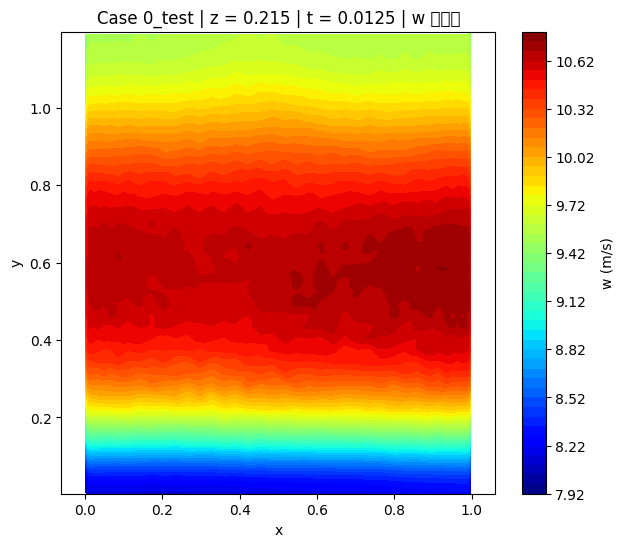

In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# ==== 配置 ====
file_path = "/home/baoheng/OpenFOAM_study/UB_wind_tunnel_simulation_LES/0_test/windfield_all_cases.h5"
case_name = "0_test"   # 选择要绘制的 case
t_target = "0.0125"    # 选择时间步
z_target = 0.215
tol = 0.01             # 截面厚度容差

# ==== 读取 HDF5 数据 ====
with h5py.File(file_path, "r") as f:
    if case_name not in f:
        raise KeyError(f"❌ HDF5 中不存在 case: {case_name}")
    case_grp = f[case_name]

    if t_target not in case_grp:
        raise KeyError(f"❌ Case {case_name} 中不存在时间步: {t_target}")
    
    coords = case_grp[t_target]["coords"][:]     # (n_cells, 3)
    velocity = case_grp[t_target]["velocity"][:] # (n_cells, 3)

# ==== 筛选 z ≈ z_target 的单元 ====
mask = np.abs(coords[:, 2] - z_target) < tol
coords_slice = coords[mask]
velocity_slice = velocity[mask]

if coords_slice.shape[0] == 0:
    raise ValueError(f"⚠️ 在 z={z_target}±{tol} 未找到单元")

# ==== 提取 w 分量（第三个分量） ====
x = coords_slice[:, 0]
y = coords_slice[:, 1]
w = velocity_slice[:, 2]   # ✅ 修正为第三个分量 (w)

# ==== 1. 创建规则网格 ====
nx, ny = 200, 200
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
Xi, Yi = np.meshgrid(xi, yi)

# ==== 2. 将散点数据插值到网格 ====
Wi = griddata((x, y), w, (Xi, Yi), method="linear")

# ==== 3. 绘制高程图（等高线填充） ====
plt.figure(figsize=(7,6))
contour = plt.contourf(Xi, Yi, Wi, levels=50, cmap="jet")
plt.colorbar(contour, label="w (m/s)")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Case {case_name} | z = {z_target} | t = {t_target} | w 高程图")
plt.axis("equal")
plt.show()
